In [285]:
import pandas as pd
import numpy as np
from scipy import optimize
import sys
sys.path.append('../../')
from PortfolioAnalysis import Backtest
from PortfolioAnalysis import Model

In [286]:
def inv(df):
    return pd.DataFrame(np.linalg.pinv(df.values), df.columns, df.index)

In [295]:
class BL:
    '''
    Black-Litterman is used to get the final combination weight
    Input:
    
    
    
    '''
    def __init__(self, df_date, df_history, df_fr, market_view, sub_view):
        self.df_date = df_date
        self.df_history = df_history
        self.df_fr = df_fr
        
        def utility(w):
            u = w.T.dot(self.E_R)-(self.Lambda/2)*w.T.dot(self.new_cov).dot(w)
            return -u

        # market_view为风险评价模型观点矩阵
        # sub_view为宏观数据算出的主观观点矩阵
        self.market_view = market_view
        self.sub_view = sub_view
        
        # 权重
        ay_weight = self.market_view.iloc[[0]]
        
        # 期望收益率平均值
        df_r = np.log(df_history/df_history.shift(1))
        market_r = (self.market_view*np.array(df_r)).dropna()
        E_r = market_r.sum().sum()
        
        # 收益率标准差
        market_sigma = np.std(market_r.sum(axis=1))
        
        # 无风险利率平均值
        mean_fr = df_fr.mean()
        
        # 风险厌恶系数
        Lambda = ((E_r-mean_fr)/(market_sigma))[0]
        self.Lambda = Lambda
        
        # 资产收益率协方差矩阵(n*n)
        market_cov = df_r.corr() 
        
        # 先验收益率（n*1） = Lambda*协方差矩阵（n*n）*权重（n*1）
        Sigma = Lambda * np.dot(market_cov , ay_weight.T)
        self.Sigma = Sigma
        
        # 观点收益Q
        sub_view = self.sub_view
        Q = sub_view[sub_view.columns[len(sub_view.columns)-1]] .sum()
        
        # 观点信心水平LC默认为80%
        LC = 0.8
        
        # CF
        P = (self.sub_view.sum(axis=0))[:-1]
        P = pd.DataFrame(P).T
        CF = np.dot(np.dot(P,market_cov),P.T)[0]
        
        # 观点误差矩阵
        Omega = pd.DataFrame([CF/LC])
        
        # 投资者信心程度，默认为1
        tao = 1
        self.tao = tao
        
        # 后验收益率 E(R)
        E_R = np.dot(inv(inv(tao*market_cov)+np.dot(np.dot(P.T,inv(Omega)),P)),\
                         (np.dot(inv(tao*market_cov),self.Sigma)+(np.dot(np.dot(P.T,inv(Omega)),Q))))
        self.E_R = E_R
        
        # 新收益率协方差矩阵
        new_cov = inv(inv(tao*market_cov)+np.dot(np.dot(P.T,inv(Omega)),P))
        self.new_cov = new_cov
        
        
        # 新的权重
        a="{'type': 'eq', 'fun': lambda w: w.sum() - 1},"
        for i in range(15):
            a = a +"{'type': 'ineq', 'fun': lambda w: w["+str(i)+"] + maxx},\
            {'type': 'ineq', 'fun': lambda w: maxx - w["+str(i)+"]},"
        cons = (eval(a[:-1]))
        w = np.array([[1/15,]*15])
        weight_new = optimize.minimize(utility,w,constraints=cons,tol = 1e-8).x
        weight_new = pd.DataFrame(weight_new).T
        for i in range(62):
            weight_new = weight_new.append(weight_new.iloc[0]) 
        weight_new.index = self.df_date
        self.weight_new = weight_new
        
    
    def print_E_R(self):
        return self.E_R
    
    def print_weight(self):
        return self.weight_new
        

In [296]:
market_view = pd.read_csv("../Risk_Parity_Model/view.csv",index_col = 0)
sub_view = pd.read_csv("../Subjective_View_Setting/Subjective_View.csv",index_col = 0)
df_history = pd.read_csv("../../Data/Data_Outsample.csv",index_col = 0)[:-28]
df_history_all = pd.read_csv("../../Data/Data_All.csv",index_col = 0)
df_date = market_view.index
df_fr = pd.DataFrame(np.repeat(0,1134))

In [356]:
view_new = pd.DataFrame(columns = df_history.columns)
start = 0
while(True):
    print("start = %d"%start)
    if(start+63>len(df_date)):
        break
    bl = BL(df_date[start:start+63], df_history[start:start+63], df_fr[start:start+63],\
            market_view[start:start+63], sub_view[start:start+63])
    view_new = pd.concat([view_new,bl.print_weight()])
    start = start + 63
view_new = view_new.dropna(axis=1)
view_new.columns = df_history.columns

start = 0
start = 63
start = 126
start = 189
start = 252
start = 315
start = 378
start = 441
start = 504
start = 567
start = 630
start = 693
start = 756
start = 819
start = 882
start = 945
start = 1008
start = 1071
start = 1134


In [318]:
# tao=1
BT_100 = Backtest.Backtest(df_date, df_history_all[252*3:252*3+63*18], view_new, df_fr, 'D')
BT_100 .get_info()

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.058594,0.266742,4.552348,0.30166


In [320]:
df_bm = pd.DataFrame(np.repeat(np.array([[1/15,]*15]),63*18,axis=0))

In [326]:
df_date

Index(['2016-03-29', '2016-03-30', '2016-03-31', '2016-04-01', '2016-04-05',
       '2016-04-06', '2016-04-07', '2016-04-08', '2016-04-11', '2016-04-12',
       ...
       '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-16',
       '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-23'],
      dtype='object', name='时间', length=1134)

In [321]:
BTM = Backtest.Backtest(df_date, df_history_all[252*3:252*3+63*18], df_bm, df_fr, 'D')
BTM.get_info()

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.025518,0.087254,3.419271,0.774552


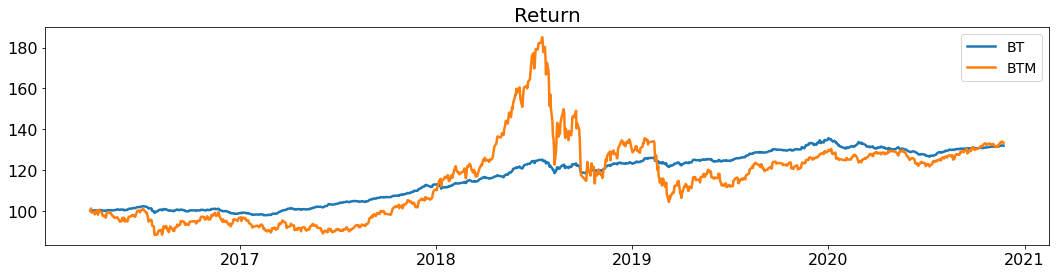

In [322]:
Backtest.Plot2(df_date,BT.df_asset,BTM.df_asset,"Return","BT","BTM")

In [348]:
Asset = pd.DataFrame([BT.df_asset,BTM.df_asset]).T
Asset.index = df_date
Asset.columns = ['BL','Market']

In [353]:
Asset.to_csv("BL_Asset.csv")

In [359]:
view_new.to_csv("view.csv")

In [93]:
df_date = df_date[0:63]
df_history = df_history[0:63]
df_fr = df_fr[0:63]
market_view = market_view[0:63]
sub_view = sub_view[0:63]

In [96]:
        ay_weight = market_view.iloc[[0]]
        
        # 期望收益率平均值
        df_r = np.log(df_history/df_history.shift(1))
        market_r = (market_view*np.array(df_r)).dropna()
        E_r = market_r.sum().sum()
        
        # 收益率标准差
        market_sigma = np.std(market_r.sum(axis=1))
        
        # 无风险利率平均值
        mean_fr = df_fr.mean()
        
        # 风险厌恶系数
        Lambda = ((E_r-mean_fr)/(market_sigma))[0]
        
        # 资产收益率协方差矩阵(n*n)
        market_cov = df_r.corr() 
        
        # 先验收益率（n*1） = Lambda*协方差矩阵（n*n）*权重（n*1）
        Sigma = Lambda * np.dot(market_cov , ay_weight.T)
        
        # 观点收益Q
        Q = sub_view[sub_view.columns[len(sub_view.columns)-1]] .sum()
        
        # 观点信心水平LC默认为80%
        LC = 0.8
        
        # CF
        P = (sub_view.sum(axis=0))[:-1]
        P = pd.DataFrame(P).T
        CF = np.dot(np.dot(P,market_cov),P.T)[0]
        
        # 观点误差矩阵
        Omega = pd.DataFrame([CF/LC])
        
        # 投资者信心程度，默认为1
        tao = 1.3
        
        # 后验收益率 E(R)
        E_R = np.dot(inv(inv(tao*market_cov)+np.dot(np.dot(P.T,inv(Omega)),P)),(np.dot(inv(tao*market_cov),Sigma)+(np.dot(np.dot(P.T,inv(Omega)),Q))))
        
        # 新收益率协方差矩阵
        new_cov = inv(inv(tao*market_cov)+np.dot(np.dot(P.T,inv(Omega)),P))
       
        # 新的权重
        
        
'''       
        weight_new = inv(Lambda*new_cov).dot(E_R).T
        for i in range(62):
            weight_new = weight_new.append(weight_new.iloc[0]) 
        weight_new.index = df_date
        weight_new = weight_new
'''

'       \nweight_new = inv(Lambda*new_cov).dot(E_R).T\nfor i in range(62):\n    weight_new = weight_new.append(weight_new.iloc[0]) \nweight_new.index = df_date\nweight_new = weight_new\n'

In [281]:
def utility(w):
    u = w.T.dot(E_R)-(Lambda/2)*w.T.dot(new_cov).dot(w)
    return -u

In [282]:
a="{'type': 'eq', 'fun': lambda w: w.sum() - 1},"
for i in range(15):
    a = a +"{'type': 'ineq', 'fun': lambda w: w["+str(i)+"] + maxx},\
    {'type': 'ineq', 'fun': lambda w: maxx - w["+str(i)+"]},"

In [283]:
maxx = 0.5
cons = (eval(a[:-1]))
        
w = np.array([[1/15,]*15])
weight_new = optimize.minimize(utility,w,constraints=cons,tol = 1).x

In [284]:
weight_new

array([-0.06092706, -0.04022218, -0.03371715, -0.01765308,  0.02678011,
       -0.02317956,  0.16423834,  0.16423834,  0.16423834,  0.16423834,
        0.16423834,  0.08667152, -0.02781903,  0.10463639,  0.16423834])

In [145]:
weight_new = pd.DataFrame(weight_new).T
for i in range(62):
    weight_new = weight_new.append(weight_new.iloc[0]) 

In [139]:
pd.DataFrame(weight_new)

0    0.999997
0    0.999997
0    0.999997
0    0.999997
0    0.999997
       ...   
0    0.999997
0    0.999997
0    0.999997
0    0.999997
0    0.999997
Length: 63, dtype: float64